In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
def filter_rows(df, pred):
    return df[df.apply(pred, axis=1)]


def summarize_answers(df, reduced=True):
    solvers = df.columns.get_level_values(0).unique()
    answers = [
        "sat", "unsat", "unknown", "wrong", "error", "timeout", "memout", "no answer",
        "segmentation fault", "segfault", "abort", "invalid", "success", "parsererror"
    ]

    data = []
    data.append(tuple([len(df[~df[(solver, "answer")].isnull()]) for solver in solvers])) # count
    for answer in answers:
        r = []
        for solver in solvers:
            vc = df[(solver, "answer")].value_counts()
            if answer in vc:
                r.append(vc[answer])
            else:
                r.append(0)
        data.append(tuple(r))
    data.append(tuple([data[1][i] + data[2][i] for i in range(len(solvers))]))  # solved

    result = pd.DataFrame(data, index=["count"] + answers + ["solved"], columns=solvers)
    if reduced:
        return filter_rows(result, (lambda x : any([x[c] != 0 for c in result.columns])))
    else:
        return result 

In [16]:
df_qfnra = pd.read_csv("stats-opt-qfnra.csv", header=[0,1], index_col=0)
summarize_answers(df_qfnra)

,CAlC-QE,CAlC-Opt,CAlC-Opt+,CDCL-OCAC,OptiMathSat
count,12152,12152,12152,12152,12152
sat,4430,4884,4923,4596,2696
unsat,4940,4940,4924,5028,5248
timeout,2631,2181,2160,2527,3973
memout,151,147,145,1,230
parsererror,0,0,0,0,5
solved,9370,9824,9847,9624,7944


In [13]:
df_qfnra_hard = pd.read_csv("stats-opt-qfnra-hard.csv", header=[0,1], index_col=0)
summarize_answers(df_qfnra_hard)

,CAlC-QE,CAlC-Opt,CAlC-Opt+,CDCL-OCAC,OptiMathSat
count,12145,12145,12145,12145,12145
sat,3201,4146,4286,3409,595
unsat,4870,4871,4817,4892,5205
timeout,3919,2983,2895,3844,6332
memout,155,145,147,0,6
parsererror,0,0,0,0,7
solved,8071,9017,9103,8301,5800


In [14]:
df_oms = pd.read_csv("stats-opt-oms.csv", header=[0,1], index_col=0)
summarize_answers(df_oms)

,CAlC-QE,CAlC-Opt,CAlC-Opt+,CDCL-OCAC,OptiMathSat
count,752,752,752,752,752
sat,0,1,1,0,5
unsat,11,11,10,148,109
timeout,717,715,715,604,638
memout,24,25,26,0,0
solved,11,12,11,148,114


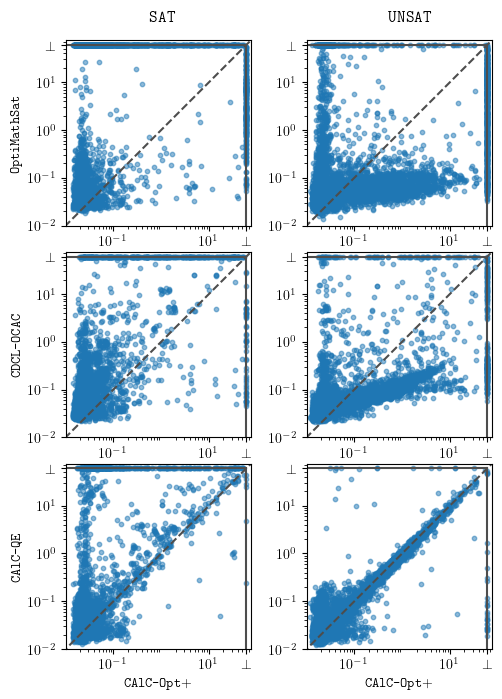

In [17]:
fig = plt.figure(figsize=(5.5,8))

plt.rcParams.update({
    "text.usetex": True,
    "font.family": 'CM'
})

def my_scatter(s1, s2, ans, df):
    field = "runtime"

    # filter specified answer
    df_ans = df[(df[(s1,"answer")] == ans) | (df[(s2,"answer")] == ans)].copy()
    ax = plt.gca()

    # convert from milliseconds to seconds
    for solver in df_ans.columns.get_level_values(0).unique():
        df_ans[(solver,'runtime')] /= 1000

    # set value for unsolved to timeout value
    maxval = 60
    df_ans.loc[(df_ans[(s1, "answer")].isin(["timeout", "memout"])), (s1, field)] = maxval
    df_ans.loc[(df_ans[(s2, "answer")].isin(["timeout", "memout"])), (s2, field)] = maxval
    ax.plot([0, maxval], [maxval, maxval], ls="-", c=".3")
    ax.plot([maxval, maxval], [0, maxval], ls="-", c=".3")

    df_ans.plot.scatter(ax=ax, x=(s1, field), y=(s2, field), alpha=0.5, s=10)

    # set log scale and add label for unsolved
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xticks(list(ax.get_xticks()) + [maxval], ax.get_xticklabels()+ ['$\\bot$'])
    ax.set_yticks(list(ax.get_yticks()) + [maxval], ax.get_yticklabels()+ ['$\\bot$'])

    ax.set_aspect("equal")
    # plot diagonal
    lower = max(ax.get_xlim()[0], ax.get_ylim()[0])
    upper = min(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.plot([lower, upper], [lower, upper], ls="--", c=".3")

    ax.set_xlim((0.01,75))
    ax.set_ylim((0.01,75))

    return ax

plt.subplot(3,2,1)
ax = my_scatter("CAlC-Opt+", "OptiMathSat", "sat", df_qfnra)
ax.set_ylabel(r"\texttt{OptiMathSat}")
ax.set_xlabel("")
plt.subplot(3,2,2)
ax = my_scatter("CAlC-Opt+", "OptiMathSat", "unsat", df_qfnra)
ax.set_ylabel("")
ax.set_xlabel("")
plt.subplot(3,2,3)
ax = my_scatter("CAlC-Opt+", "CDCL-OCAC", "sat", df_qfnra)
ax.set_ylabel(r"\texttt{CDCL-OCAC}")
ax.set_xlabel("")
plt.subplot(3,2,4)
ax = my_scatter("CAlC-Opt+", "CDCL-OCAC", "unsat", df_qfnra)
ax.set_ylabel("")
ax.set_xlabel("")
plt.subplot(3,2,5)
ax = my_scatter("CAlC-Opt+", "CAlC-QE", "sat", df_qfnra)
ax.set_ylabel(r"\texttt{CAlC-QE}")
ax.set_xlabel(r"\texttt{CAlC-Opt}+")
plt.subplot(3,2,6)
ax = my_scatter("CAlC-Opt+", "CAlC-QE", "unsat", df_qfnra)
ax.set_ylabel("")
ax.set_xlabel(r"\texttt{CAlC-Opt}+")

fig.text(0.3, 0.9, r'\texttt{SAT}', ha='center', fontsize=12)
fig.text(0.75, 0.9, r'\texttt{UNSAT}', ha='center', fontsize=12)

plt.subplots_adjust(wspace=0.3, hspace=0.1)
plt.show()